In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rosbag
import pymap3d as pm

from scipy.signal import savgol_filter
%matplotlib inline

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
def wrap_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

def to_euler(x, y, z, w):
    """Return as xyz (roll pitch yaw) Euler angles."""
    roll = np.arctan2(2 * (w * x + y * z), 1 - 2 * (x**2 + y**2))
    pitch = np.arcsin(2 * (w * y - z * x))
    yaw = np.arctan2(2 * (w * z + x * y), 1 - 2 * (y**2 + z**2))
    return np.array([roll, pitch, yaw])

In [3]:
ls

bag_output_ukf_polban0807_02.bag
kf_gps.ipynb
kf_gps.py
__pycache__/
speed.png
state_gps_lab_u_turn_kanan_2020-08-18-17-21-07.bag
Untitled.ipynb
yaw.png


In [4]:
bag = rosbag.Bag('state_gps_lab_u_turn_kanan_2020-08-18-17-21-07.bag')

In [5]:
lat0, lon0, h0 = -6.8712, 107.5738, 768
gps_t = []
gps_pos = []
gps_cov = []
for topic, msg, _ in bag.read_messages(topics=['/fix']):
    gps_t.append(msg.header.stamp.to_sec())
    gps_pos.append(pm.geodetic2enu(msg.latitude, msg.longitude, msg.altitude, lat0, lon0, h0))
    gps_cov.append(msg.position_covariance)
gps_t = np.array(gps_t)
gps_pos = np.array(gps_pos)
gps_cov = np.array(gps_cov).reshape(-1,3,3)

# Ambil yang bagus-bagus aja
gnss_pos = np.copy(gps_pos[:-1])
gnss_t = np.copy(gps_t[:-1])
gnss_cov = np.copy(gps_cov[:-1])

In [6]:
gps_pos = (-1) * np.copy(gnss_pos[:,:2])
gps_t = np.copy(gnss_t)

In [9]:
gse_t = []
gse_x = []
gse_y = []
gse_vx = []
gse_vy = []
gse_yaw = []
for topic, msg, _ in bag.read_messages(topics=['/gps_state_estimation']):
    gse_t.append(msg.header.stamp.to_sec())
    gse_x.append(msg.x)
    gse_y.append(msg.y)
    gse_vx.append(msg.vx)
    gse_vy.append(msg.vy)
    gse_yaw.append(msg.yaw)
gse_t = np.array(gse_t)
gse_x = np.array(gse_x)
gse_y = np.array(gse_y)
gse_vx = np.array(gse_vx)
gse_vy = np.array(gse_vy)
gse_yaw = np.array(gse_yaw)

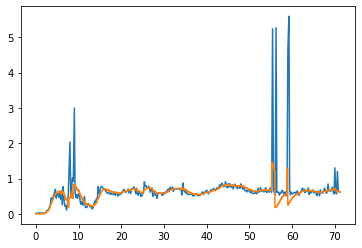

In [15]:
dgps = gps_pos[1:] - gps_pos[:-1]
v_gps = np.zeros((dgps.shape[0],2))
v_gps[:,0] = dgps[:,0] / (gps_t[1:] - gps_t[:-1])
v_gps[:,1] = dgps[:,1] / (gps_t[1:] - gps_t[:-1])
v_gps_norm = np.linalg.norm(v_gps, axis=-1)
plt.plot(gps_t[:-1] - gps_t[0], v_gps_norm, label='gps murni')
plt.plot(gse_t - gse_t[0], np.sqrt(gse_vx**2 + gse_vy**2))

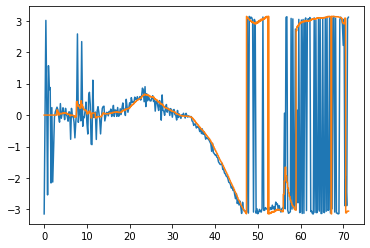

In [18]:
diff = gps_pos[1:] - gps_pos[:-1]
plt.plot(gps_t[:-1] - gps_t[0], np.arctan2(diff[:,1], diff[:,0]))
plt.plot(gse_t - gse_t[0], gse_yaw)